## Описание проекта

Сфера деятельности - такси.

Предоставлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

### Описание данных

Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = [0])

In [3]:
# сгруппируем данные по часу
df = df.resample('1H').sum()

# 2. Анализ

In [4]:
# Посмотрим, в хронологическом ли порядке расположены даты
df.index.is_monotonic
# True => в хронологическом

True

Text(0, 0.5, 'frequency')

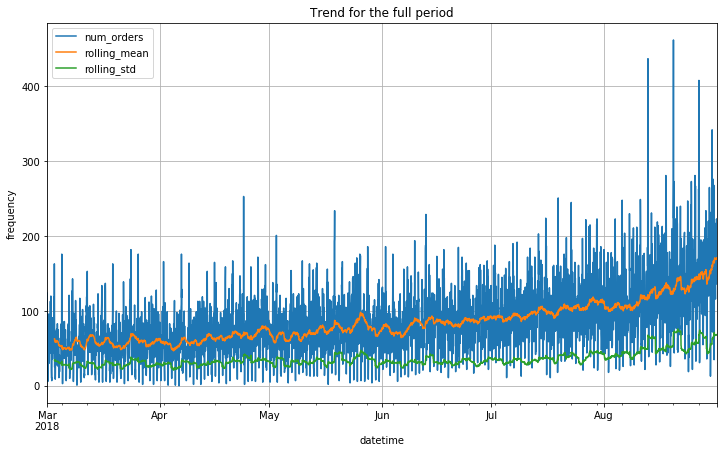

In [5]:
# Посмотрим на графике скользящее среднее
df_rolling_mean = df.resample('1H').sum()
df_rolling_mean['rolling_mean'] = df_rolling_mean['num_orders'].rolling(50).mean()
df_rolling_mean['rolling_std'] = df_rolling_mean['num_orders'].rolling(50).std()
plt.rcParams["figure.figsize"] = (12, 7)
df_rolling_mean.plot()
plt.grid()
plt.title('Trend for the full period')
plt.ylabel('frequency')
# График показывает, что в более жаркие времена года число заказов в аэропортах увеличивается, что вполне логично
# Однако для нас поставлена другая задача - нужно спрогнозировать количество заказов такси на следующий час.
# Стоит отметить, что временной ряд не стационарный (среднее и отклонение изменяется)

Text(0, 0.5, 'frequency')

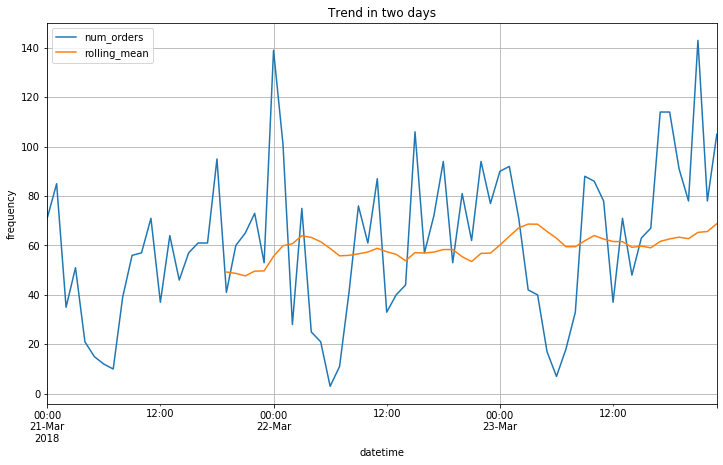

In [6]:
# Возьмем для наглядности период с 21.03.2018 по 23.03.2018 (для остальных дат наблюдается похожая картина)
df_several_days = df['2018-03-21': '2018-03-23'].resample('1H').sum()
df_several_days['rolling_mean'] = df_several_days.rolling(20).mean()
df_several_days.plot()
plt.grid()
plt.title('Trend in two days')
plt.ylabel('frequency')
# Видно, что пик заказов наблюдается в послеобеденное время и в вечернее время. 

Text(0, 0.5, 'frequency')

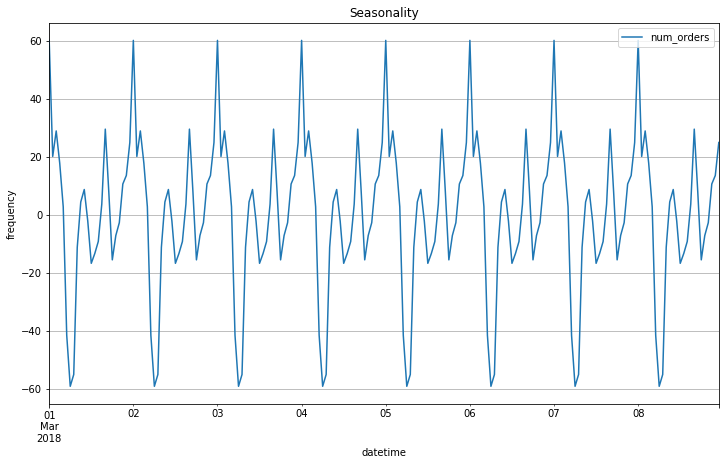

In [7]:
# Посмотрим график сезонной составляющей 
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid()
plt.ylabel('frequency')
# Видно, что пик заказывает приходится на вторую половину дня, особенно ближе к полуночи.
# Подобная зависимость характерна для всего временного промежутка в датасете.
# Похоже, что это стохастический стационарный процесс.

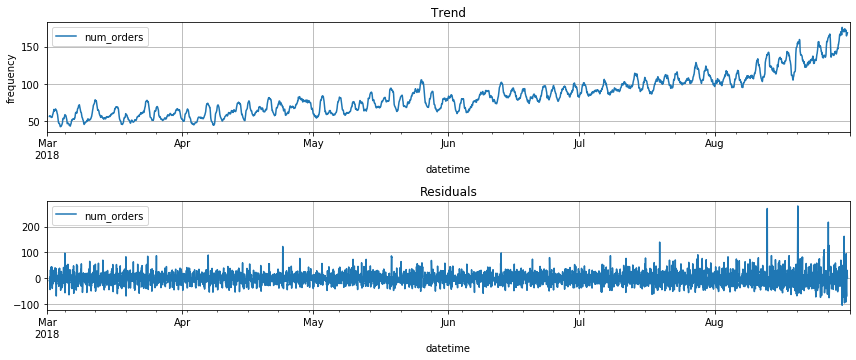

In [8]:
# Посмотрим тренд и остаток
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid()
plt.ylabel('frequency')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid()
plt.tight_layout()

# 3. Обучение

In [9]:
# Создание признаков
def make_features(df, max_lag, rolling_mean_size):
    # календарные признаки
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['sin_hour'] = np.sin(2*np.pi*df.index.hour/24)
    df['cos_hour'] = np.cos(2*np.pi*df.index.hour/24)
    # отстающие значения
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    # скользящее среднее    
    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

# с помощью поиска по сетке были выбраны оптимальные параметры
make_features(df, 170, 20)
print(df.head())

                     num_orders  day  dayofweek  hour  sin_hour  cos_hour  \
datetime                                                                    
2018-03-01 00:00:00         124    1          3     0  0.000000  1.000000   
2018-03-01 01:00:00          85    1          3     1  0.258819  0.965926   
2018-03-01 02:00:00          71    1          3     2  0.500000  0.866025   
2018-03-01 03:00:00          66    1          3     3  0.707107  0.707107   
2018-03-01 04:00:00          43    1          3     4  0.866025  0.500000   

                     lag_1  lag_2  lag_3  lag_4  ...  lag_162  lag_163  \
datetime                                         ...                     
2018-03-01 00:00:00    NaN    NaN    NaN    NaN  ...      NaN      NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN  ...      NaN      NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN  ...      NaN      NaN   
2018-03-01 03:00:00   71.0   85.0  124.0    NaN  ...      NaN      NaN   
2018-03-01 04:00

In [10]:
# Разделение исходного датафрейма на тренировочный и тестовый
train, test = train_test_split(df, shuffle=False, test_size = 0.1, random_state = 12345)
print('Проверка минимального и максимального значений индексов для тренировочного датасета: ', 
      train.index.min(), train.index.max())
print('Проверка минимального и максимального значений индексов для тестового датасета: ', 
      test.index.min(), test.index.max())
train = train.dropna()
train, valid = train_test_split(train, shuffle=False, test_size=0.3, random_state=12345)

Проверка минимального и максимального значений индексов для тренировочного датасета:  2018-03-01 00:00:00 2018-08-13 13:00:00
Проверка минимального и максимального значений индексов для тестового датасета:  2018-08-13 14:00:00 2018-08-31 23:00:00


In [11]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

### Линейная регрессия 

In [12]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr_valid = model_lr.predict(features_valid)
rmse_lr_valid = mean_squared_error(np.array(target_valid), predict_lr_valid)**0.5
print('Качество модели Linear Regression на валидационной выборке (корень из средней квадратичной ошибки):', rmse_lr_valid)

Качество модели Linear Regression на валидационной выборке (корень из средней квадратичной ошибки): 25.74607061290162


### CatBoost

In [13]:
model_cb = CatBoostRegressor(random_state = 12345, iterations = 300)
parameters_cb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
search_cb = RandomizedSearchCV(model_cb, parameters_cb, cv = 5, n_jobs = -1, random_state = 12345)
search_cb.fit(features_train, target_train, verbose = 100)
best_cb = search_cb.best_estimator_
predict_cb_valid = best_cb.predict(features_valid)
rmse_cb_valid = mean_squared_error(np.array(target_valid), predict_cb_valid)**0.5
print('Качество модели CatBoost на валидационной выборке (корень из средней квадратичной ошибки):', rmse_cb_valid)

0:	learn: 33.6354299	total: 638ms	remaining: 3m 10s
100:	learn: 22.9973658	total: 48.1s	remaining: 1m 34s
200:	learn: 18.6664692	total: 1m 35s	remaining: 47.2s
299:	learn: 16.4384814	total: 2m 22s	remaining: 0us
0:	learn: 33.7868578	total: 483ms	remaining: 2m 24s
100:	learn: 23.1919432	total: 47.7s	remaining: 1m 34s
200:	learn: 18.8522583	total: 1m 34s	remaining: 46.6s
299:	learn: 16.6580701	total: 2m 21s	remaining: 0us
0:	learn: 33.4850757	total: 351ms	remaining: 1m 44s
100:	learn: 22.6078752	total: 46.6s	remaining: 1m 31s
200:	learn: 18.2846671	total: 1m 32s	remaining: 45.7s
299:	learn: 16.1449237	total: 2m 18s	remaining: 0us
0:	learn: 32.5031538	total: 319ms	remaining: 1m 35s
100:	learn: 22.1243042	total: 45.8s	remaining: 1m 30s
200:	learn: 17.8908934	total: 1m 31s	remaining: 45s
299:	learn: 15.7301224	total: 2m 16s	remaining: 0us
0:	learn: 32.8340454	total: 376ms	remaining: 1m 52s
100:	learn: 22.1469576	total: 46.4s	remaining: 1m 31s
200:	learn: 17.8637551	total: 1m 32s	remaining: 

### LightGBM

In [14]:
model_lgb = lgb.LGBMRegressor(random_state=12345)
parameters_lgb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1],
                 'n_estimators': range(100, 501, 50)}
search_lgb = RandomizedSearchCV(model_lgb, parameters_lgb, cv = 5, n_jobs = -1, random_state = 12345)
search_lgb.fit(features_train, target_train)
best_lgb = search_lgb.best_estimator_
predict_lgb_valid = best_lgb.predict(features_valid)
rmse_lgb_valid = mean_squared_error(np.array(target_valid), predict_lgb_valid)**0.5
print('Качество модели LighGBM на валидационной выборке (корень из средней квадратичной ошибки):', rmse_lgb_valid)

Качество модели LighGBM на валидационной выборке (корень из средней квадратичной ошибки): 27.31314204029764


In [16]:
data_model = [['LinearRegression', rmse_lr_valid], 
              ['CatBoost', rmse_cb_valid], 
              ['LightGBM', rmse_lgb_valid]]
columns_model = ['model', 'rmse']
table_model = pd.DataFrame(data = data_model, columns = columns_model)
table_model

,model,rmse
0,LinearRegression,25.746071
1,CatBoost,27.894777
2,LightGBM,27.313142


# 4. Тестирование

### Линейная регрессия

In [17]:
predict_lr_test = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(np.array(target_test), predict_lr_test)**0.5
print('Качество модели Linear Regression на тестовой выборке (корень из средней квадратичной ошибки):', rmse_lr_test)

Качество модели Linear Regression на тестовой выборке (корень из средней квадратичной ошибки): 36.23479586254034


## Вывод

Как видно из таблицы, наилучшей моделью является линейная регрессия по качеству. Скорее всего, и по скорости линейная регрессия будет быстрее, чем градиентный бустинг. В работе не рассмотрены другие модели (например, решающее дерево и случайный лес). Однако, возможно, их использование будет нерационально, так как для получения необходимого качества придется пожертвовать скоростью работы.